In [3]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
parse_dates=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
df_orders = pd.read_csv('olist_orders_dataset.csv',parse_dates=parse_dates)
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [16]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()
#df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_purchase_year                       int64
order_purchase_month                      int64
order_purchase_month_name                object
order_purchase_year_month                object
order_purchase_date                      object
order_purchase_day                        int64
order_purchase_dayofweek                  int64
order_purchase_dayofweek_name            object
order_purchase_hour                       int64
order_purchase_time_day                category
dtype: object

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['customer_unique_id', 'year_month', 'payment_value'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

/home/rahul/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning:

Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.



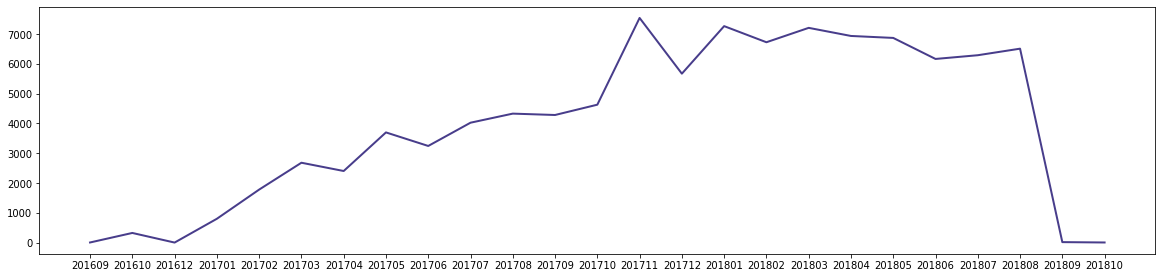

In [27]:
fig = plt.figure(constrained_layout=True, figsize=(20, 10))

# Axis definition
#gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)

In [29]:
#Feature Extraction

df_orders['order_process_time'] = df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']

df_orders['order_delivery_time'] = df_orders['order_delivered_customer_date'] - df_orders['order_delivered_carrier_date']

df_orders['order_accuracy_time'] = df_orders['order_estimated_delivery_date'] - df_orders['order_delivered_customer_date'] 

df_orders['order_approved_time'] = df_orders['order_approved_at'] - df_orders['order_purchase_timestamp'] 

Text(0, 0.5, 'Time (Day)')

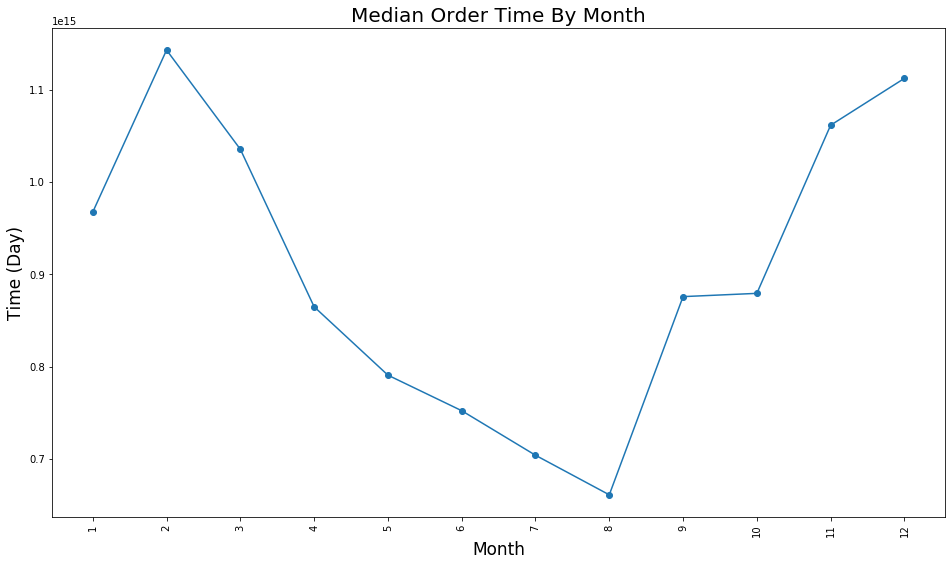

In [33]:
order_time_by_month = df_orders['order_process_time'].groupby(df_orders['order_purchase_month']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

#Membuat visualisasinya
fig=plt.figure(figsize=(16,9))
plt.plot(order_time_by_month.index, order_time_by_month.values, marker='o')
plt.title('Median Order Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
#         ['January', 'February', 'March','April', 'Mei', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

In [ ]:
delivery_time_by_month = df_orders['order_delivery_time'].groupby(df_orders['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

#Membuat visualisasinya
fig=plt.figure(figsize=(16,9))
plt.plot(delivery_time_by_month.index, delivery_time_by_month.values / 86400, marker='o')
plt.title('Median Delivery Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
         # ['January', 'February', 'March','April', 'Mei', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

In [38]:
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
order_purchase_year                 0
order_purchase_month                0
order_purchase_month_name           0
order_purchase_year_month           0
order_purchase_date                 0
order_purchase_day                  0
order_purchase_dayofweek            0
order_purchase_dayofweek_name       0
order_purchase_hour                 0
order_purchase_time_day             0
order_process_time               2965
order_delivery_time              2966
order_accuracy_time              2965
order_approved_time               160
dtype: int64

In [39]:
df_orders.dtypes

order_id                                  object
customer_id                               object
order_status                              object
order_purchase_timestamp          datetime64[ns]
order_approved_at                 datetime64[ns]
order_delivered_carrier_date      datetime64[ns]
order_delivered_customer_date     datetime64[ns]
order_estimated_delivery_date     datetime64[ns]
order_purchase_year                        int64
order_purchase_month                       int64
order_purchase_month_name                 object
order_purchase_year_month                 object
order_purchase_date                       object
order_purchase_day                         int64
order_purchase_dayofweek                   int64
order_purchase_dayofweek_name             object
order_purchase_hour                        int64
order_purchase_time_day                 category
order_process_time               timedelta64[ns]
order_delivery_time              timedelta64[ns]
order_accuracy_time 

In [40]:
df_orders[['purchase','approved','delivered_carrier','delivered_customer','estimated_delivery']] = df_orders[['order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date','order_delivered_customer_date',
'order_estimated_delivery_date']].apply(pd.to_datetime)
df_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_process_time,order_delivery_time,order_accuracy_time,order_approved_time,purchase,approved,delivered_carrier,delivered_customer,estimated_delivery
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,8 days 10:28:40,6 days 01:30:13,7 days 02:34:47,0 days 00:10:42,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,13 days 18:46:08,12 days 00:56:45,5 days 08:32:15,1 days 06:42:50,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,9 days 09:27:40,9 days 04:16:29,17 days 05:53:31,0 days 00:16:34,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,Nov,201711,20171118,18,5,Sat,19,Night,13 days 05:00:36,9 days 10:48:43,12 days 23:31:18,0 days 00:17:53,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,Feb,201802,20180213,13,1,Tue,21,Night,2 days 20:58:23,1 days 22:30:28,9 days 05:42:58,0 days 01:01:50,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,2017,3,Mar,201703,20170309,9,3,Thu,9,Morning,8 days 05:13:56,7 days 03:49:58,10 days 08:51:59,0 days 00:00:00,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,2018,2,Feb,201802,20180206,6,1,Tue,12,Morning,22 days 04:38:58,20 days 18:15:14,1 days 06:22:04,0 days 00:11:39,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,2017,8,Aug,201708,20170827,27,6,Sun,14,Afternoon,24 days 20:37:34,23 days 14:31:51,5 days 12:35:43,0 days 00:17:33,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2018,1,Jan,201801,20180108,8,0,Mon,21,Night,17 days 02:04:27,13 days 07:57:51,20 days 00:27:06,0 days 00:07:54,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 

In [41]:
df_orders.dtypes

order_id                                  object
customer_id                               object
order_status                              object
order_purchase_timestamp          datetime64[ns]
order_approved_at                 datetime64[ns]
order_delivered_carrier_date      datetime64[ns]
order_delivered_customer_date     datetime64[ns]
order_estimated_delivery_date     datetime64[ns]
order_purchase_year                        int64
order_purchase_month                       int64
order_purchase_month_name                 object
order_purchase_year_month                 object
order_purchase_date                       object
order_purchase_day                         int64
order_purchase_dayofweek                   int64
order_purchase_dayofweek_name             object
order_purchase_hour                        int64
order_purchase_time_day                 category
order_process_time               timedelta64[ns]
order_delivery_time              timedelta64[ns]
order_accuracy_time 

In [42]:
df_orders=df_orders.drop(['order_purchase_timestamp','order_approved_at',
            'order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'], axis=1)

In [43]:
df_orders

,order_id,customer_id,order_status,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_process_time,order_delivery_time,order_accuracy_time,order_approved_time,purchase,approved,delivered_carrier,delivered_customer,estimated_delivery
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,8 days 10:28:40,6 days 01:30:13,7 days 02:34:47,0 days 00:10:42,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,13 days 18:46:08,12 days 00:56:45,5 days 08:32:15,1 days 06:42:50,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,9 days 09:27:40,9 days 04:16:29,17 days 05:53:31,0 days 00:16:34,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017,11,Nov,201711,20171118,18,5,Sat,19,Night,13 days 05:00:36,9 days 10:48:43,12 days 23:31:18,0 days 00:17:53,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018,2,Feb,201802,20180213,13,1,Tue,21,Night,2 days 20:58:23,1 days 22:30:28,9 days 05:42:58,0 days 01:01:50,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017,3,Mar,201703,20170309,9,3,Thu,9,Morning,8 days 05:13:56,7 days 03:49:58,10 days 08:51:59,0 days 00:00:00,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018,2,Feb,201802,20180206,6,1,Tue,12,Morning,22 days 04:38:58,20 days 18:15:14,1 days 06:22:04,0 days 00:11:39,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017,8,Aug,201708,20170827,27,6,Sun,14,Afternoon,24 days 20:37:34,23 days 14:31:51,5 days 12:35:43,0 days 00:17:33,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018,1,Jan,201801,20180108,8,0,Mon,21,Night,17 days 02:04:27,13 days 07:57:51,20 days 00:27:06,0 days 00:07:54,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


In [44]:
df_orders['purchase_yr'] = df_orders['purchase'].dt.year
df_orders['purchase_mo'] = df_orders['purchase'].dt.month
df_orders['purchase_dy'] = df_orders['purchase'].dt.day
df_orders['purchase_hr'] = df_orders['purchase'].dt.hour
df_orders['purchase_mi'] = df_orders['purchase'].dt.minute
df_orders['purchase_sec'] = df_orders['purchase'].dt.second

In [45]:
df_orders['approved_yr'] = df_orders['approved'].dt.year
df_orders['approved_mo'] = df_orders['approved'].dt.month
df_orders['approved_dy'] = df_orders['approved'].dt.day
df_orders['approved_hr'] = df_orders['approved'].dt.hour
df_orders['approved_mi'] = df_orders['approved'].dt.minute
df_orders['approved_sec'] = df_orders['approved'].dt.second

In [46]:
df_orders['delivered_carrier_yr'] = df_orders['delivered_carrier'].dt.year
df_orders['delivered_carrier_mo'] = df_orders['delivered_carrier'].dt.month
df_orders['delivered_carrier_dy'] = df_orders['delivered_carrier'].dt.day
df_orders['delivered_carrier_hr'] = df_orders['delivered_carrier'].dt.hour
df_orders['delivered_carrier_mi'] = df_orders['delivered_carrier'].dt.minute
df_orders['delivered_carrier_sec'] = df_orders['delivered_carrier'].dt.second

In [47]:
df_orders['delivered_customer_yr'] = df_orders['delivered_customer'].dt.year
df_orders['delivered_customer_mo'] = df_orders['delivered_customer'].dt.month
df_orders['delivered_customer_dy'] = df_orders['delivered_customer'].dt.day
df_orders['delivered_customer_hr'] = df_orders['delivered_customer'].dt.hour
df_orders['delivered_customer_mi'] = df_orders['delivered_customer'].dt.minute
df_orders['delivered_customer_sec'] = df_orders['delivered_customer'].dt.second

In [48]:
df_orders['estimated_delivery_yr'] = df_orders['estimated_delivery'].dt.year
df_orders['estimated_delivery_mo'] = df_orders['estimated_delivery'].dt.month
df_orders['estimated_delivery_dy'] = df_orders['estimated_delivery'].dt.day

In [54]:
#od=od.drop(['purchase','approved',
  #           'delivered_carrier','delivered_customer','estimated_delivery'], axis=1)

In [49]:
df_orders

,order_id,customer_id,order_status,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_process_time,order_delivery_time,order_accuracy_time,order_approved_time,purchase,approved,delivered_carrier,delivered_customer,estimated_delivery,purchase_yr,purchase_mo,purchase_dy,purchase_hr,purchase_mi,purchase_sec,approved_yr,approved_mo,approved_dy,approved_hr,approved_mi,approved_sec,delivered_carrier_yr,delivered_carrier_mo,delivered_carrier_dy,delivered_carrier_hr,delivered_carrier_mi,delivered_carrier_sec,delivered_customer_yr,delivered_customer_mo,delivered_customer_dy,delivered_customer_hr,delivered_customer_mi,delivered_customer_sec,estimated_delivery_yr,estimated_delivery_mo,estimated_delivery_dy
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,8 days 10:28:40,6 days 01:30:13,7 days 02:34:47,0 days 00:10:42,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,2,10,56,33,2017.0,10.0,2.0,11.0,7.0,15.0,2017.0,10.0,4.0,19.0,55.0,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,13 days 18:46:08,12 days 00:56:45,5 days 08:32:15,1 days 06:42:50,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,24,20,41,37,2018.0,7.0,26.0,3.0,24.0,27.0,2018.0,7.0,26.0,14.0,31.0,0.0,2018.0,8.0,7.0,15.0,27.0,45.0,2018,8,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,9 days 09:27:40,9 days 04:16:29,17 days 05:53:31,0 days 00:16:34,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,8,8,38,49,2018.0,8.0,8.0,8.0,55.0,23.0,2018.0,8.0,8.0,13.0,50.0,0.0,2018.0,8.0,17.0,18.0,6.0,29.0,2018,9,4
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017,11,Nov,201711,20171118,18,5,Sat,19,Night,13 days 05:00:36,9 days 10:48:43,12 days 23:31:18,0 days 00:17:53,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,18,19,28,6,2017.0,11.0,18.0,19.0,45.0,59.0,2017.0,11.0,22.0,13.0,39.0,59.0,2017.0,12.0,2.0,0.0,28.0,42.0,2017,12,15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018,2,Feb,201802,20180213,13,1,Tue,21,Night,2 days 20:58:23,1 days 22:30:28,9 days 05:42:58,0 days 01:01:50,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,13,21,18,39,2018.0,2.0,13.0,22.0,20.0,29.0,2018.0,2.0,14.0,19.0,46.0,34.0,2018.0,2.0,16.0,18.0,17.0,2.0,2018,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017,3,Mar,201703,20170309,9,3,Thu,9,Morning,8 days 05:13:56,7 days 03:49:58,10 days 08:51:59,0 days 00:00:00,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,2017,3,9,9,54,5,2017.0,3.0,9.0,9.0,54.0,5.0,2017.0,3.0,10.0,11.0,18.0,3.0,2017.0,3.0,17.0,15.0,8.0,1.0,2017,3,28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018,2,Feb,201802,20180206,6,1,Tue,12,Morning,22 days 04:38:58,20 days 18:15:14,1 days 06:22:04,0 days 00:11:39,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,2018,2,6,12,58,58,2018.0,2.0,6.0,13.0,10.0,37.0,2018.0,2.0,7.0,23.0,22.0,42.0,2018.0,2.0,28.0,17.0,37.0,56.0,2018,3,2
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017,8,Aug,201708,20170827,27,

In [56]:
df_orders.isna().sum()

order_id                     0
customer_id                  0
order_status                 0
purchase_yr                  0
purchase_mo                  0
purchase_dy                  0
purchase_hr                  0
purchase_mi                  0
purchase_sec                 0
approved_yr                160
approved_mo                160
approved_dy                160
approved_hr                160
approved_mi                160
approved_sec               160
delivered_carrier_yr      1783
delivered_carrier_mo      1783
delivered_carrier_dy      1783
delivered_carrier_hr      1783
delivered_carrier_mi      1783
delivered_carrier_sec     1783
delivered_customer_yr     2965
delivered_customer_mo     2965
delivered_customer_dy     2965
delivered_customer_hr     2965
delivered_customer_mi     2965
delivered_customer_sec    2965
estimated_delivery_yr        0
estimated_delivery_mo        0
estimated_delivery_dy        0
dtype: int64

In [50]:
df_orders.mean()

/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



order_purchase_year                             2017.54
order_purchase_month                            6.03222
order_purchase_year_month                           inf
order_purchase_date                                 inf
order_purchase_day                              15.5059
order_purchase_dayofweek                        2.75573
order_purchase_hour                             14.7708
order_process_time           12 days 13:24:31.879068369
order_delivery_time           9 days 07:55:59.254148743
order_accuracy_time          11 days 04:17:55.957616402
order_approved_time           0 days 10:25:08.739486910
purchase_yr                                     2017.54
purchase_mo                                     6.03222
purchase_dy                                     15.5059
purchase_hr                                     14.7708
purchase_mi                                     29.5276
purchase_sec                                    29.5202
approved_yr                                     

In [52]:
# replacing na/null values in each columns by the mean of each column
df_orders.fillna(df_orders.mean(), inplace=True)

/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



In [53]:
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_year                 0
order_purchase_month                0
order_purchase_month_name           0
order_purchase_year_month           0
order_purchase_date                 0
order_purchase_day                  0
order_purchase_dayofweek            0
order_purchase_dayofweek_name       0
order_purchase_hour                 0
order_purchase_time_day             0
order_process_time                  0
order_delivery_time                 0
order_accuracy_time                 0
order_approved_time                 0
purchase                            0
approved                          160
delivered_carrier                1783
delivered_customer               2965
estimated_delivery                  0
purchase_yr                         0
purchase_mo                         0
purchase_dy                         0
purchase_hr                         0
purchase_mi 

In [54]:
df_orders.tail()

,order_id,customer_id,order_status,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_process_time,order_delivery_time,order_accuracy_time,order_approved_time,purchase,approved,delivered_carrier,delivered_customer,estimated_delivery,purchase_yr,purchase_mo,purchase_dy,purchase_hr,purchase_mi,purchase_sec,approved_yr,approved_mo,approved_dy,approved_hr,approved_mi,approved_sec,delivered_carrier_yr,delivered_carrier_mo,delivered_carrier_dy,delivered_carrier_hr,delivered_carrier_mi,delivered_carrier_sec,delivered_customer_yr,delivered_customer_mo,delivered_customer_dy,delivered_customer_hr,delivered_customer_mi,delivered_customer_sec,estimated_delivery_yr,estimated_delivery_mo,estimated_delivery_dy
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017,3,Mar,201703,20170309,9,3,Thu,9,Morning,8 days 05:13:56,7 days 03:49:58,10 days 08:51:59,0 days 00:00:00,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,2017,3,9,9,54,5,2017.0,3.0,9.0,9.0,54.0,5.0,2017.0,3.0,10.0,11.0,18.0,3.0,2017.0,3.0,17.0,15.0,8.0,1.0,2017,3,28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018,2,Feb,201802,20180206,6,1,Tue,12,Morning,22 days 04:38:58,20 days 18:15:14,1 days 06:22:04,0 days 00:11:39,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,2018,2,6,12,58,58,2018.0,2.0,6.0,13.0,10.0,37.0,2018.0,2.0,7.0,23.0,22.0,42.0,2018.0,2.0,28.0,17.0,37.0,56.0,2018,3,2
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017,8,Aug,201708,20170827,27,6,Sun,14,Afternoon,24 days 20:37:34,23 days 14:31:51,5 days 12:35:43,0 days 00:17:33,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,2017,8,27,14,46,43,2017.0,8.0,27.0,15.0,4.0,16.0,2017.0,8.0,28.0,20.0,52.0,26.0,2017.0,9.0,21.0,11.0,24.0,17.0,2017,9,27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018,1,Jan,201801,20180108,8,0,Mon,21,Night,17 days 02:04:27,13 days 07:57:51,20 days 00:27:06,0 days 00:07:54,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2018,1,8,21,28,27,2018.0,1.0,8.0,21.0,36.0,21.0,2018.0,1.0,12.0,15.0,35.0,3.0,2018.0,1.0,25.0,23.0,32.0,54.0,2018,2,15
99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018,3,Mar,201803,20180308,8,3,Thu,20,Night,7 days 16:11:00,6 days 14:56:31,17 days 10:51:30,0 days 14:22:58,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03,2018,3,8,20,57,30,2018.0,3.0,9.0,11.0,20.0,28.0,2018.0,3.0,9.0,22.0,11.0,59.0,2018.0,3.0,16.0,13.0,8.0,30.0,2018,4,3


Text(0, 0.5, 'Time (Day)')

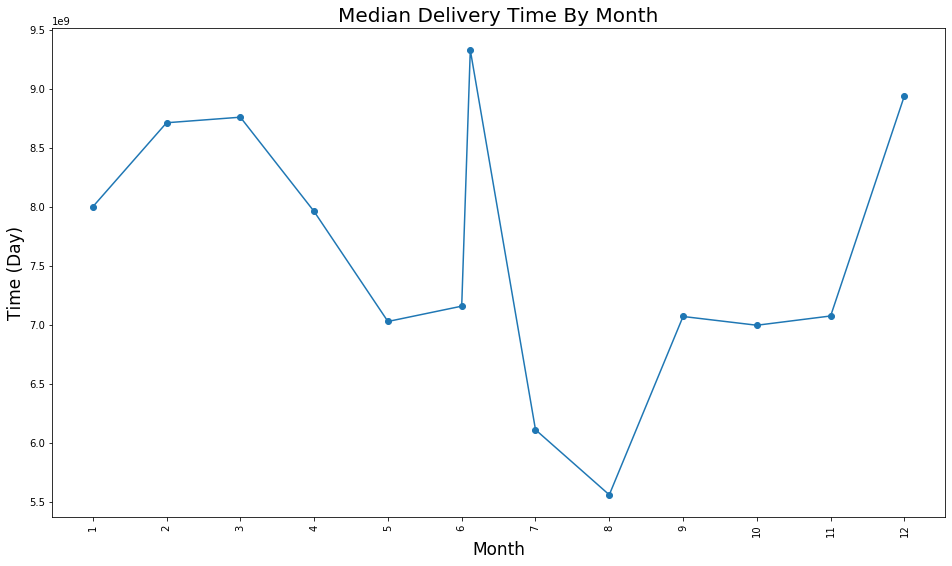

In [57]:
delivery_time_by_month = df_orders['order_delivery_time'].groupby(df_orders['delivered_customer_mo']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

#Membuat visualisasinya
fig=plt.figure(figsize=(16,9))
plt.plot(delivery_time_by_month.index, delivery_time_by_month.values / 86400, marker='o')
plt.title('Median Delivery Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
         # ['January', 'February', 'March','April', 'Mei', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Day)')

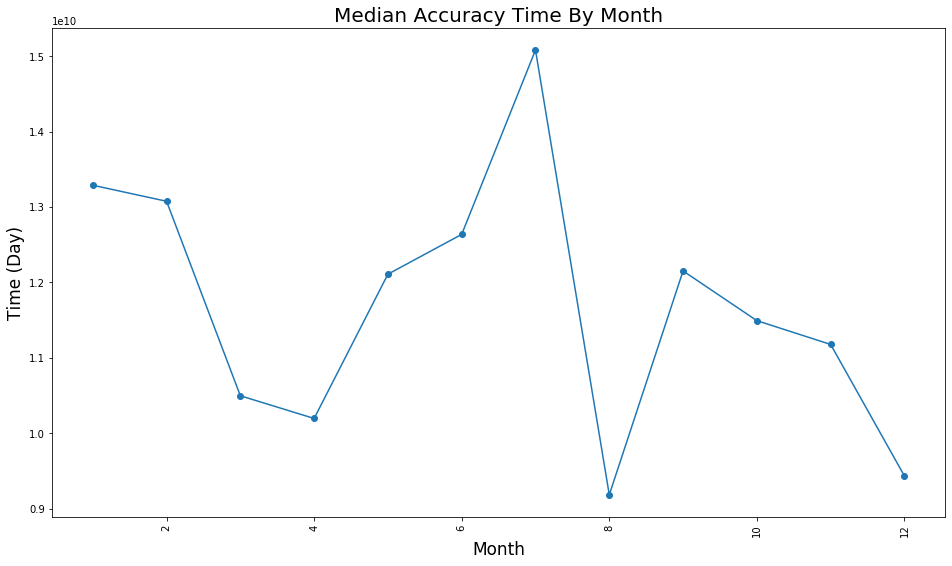

In [58]:
accuracy_time_by_month = df_orders['order_accuracy_time'].groupby(df_orders['estimated_delivery_mo']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

#Membuat visualisasinya
fig=plt.figure(figsize=(16,9))
plt.plot(accuracy_time_by_month.index, accuracy_time_by_month.values / 86400, marker='o')
plt.title('Median Accuracy Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          #['January', 'February', 'March','April', 'Mei', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Minutes)')

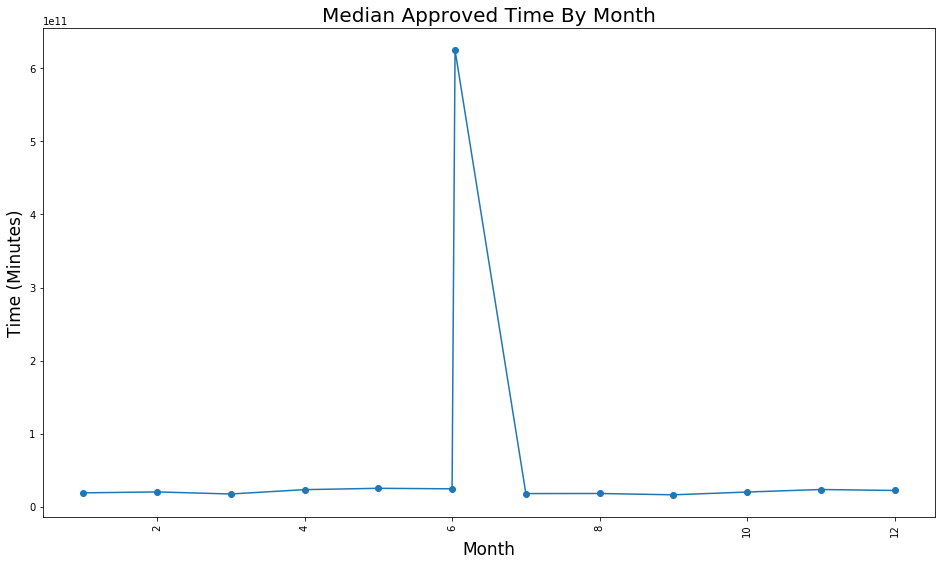

In [59]:
approved_time_by_month = df_orders['order_approved_time'].groupby(df_orders['approved_mo']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

#Membuat visualisasinya
fig=plt.figure(figsize=(16,9))
plt.plot(approved_time_by_month.index, approved_time_by_month.values / 60, marker='o')
plt.title('Median Approved Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
         # ['January', 'February', 'March','April', 'Mei', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
          rotation=90)
plt.ylabel('Time (Minutes)',fontsize=17)

In [61]:
# function to encode Native Country
dicts ={}
count = 0
for i in od.order_status.unique():
    dicts[i] = count
    count +=1
dicts

{'delivered': 0,
 'invoiced': 1,
 'shipped': 2,
 'processing': 3,
 'unavailable': 4,
 'canceled': 5,
 'created': 6,
 'approved': 7}

In [62]:
od['order_status'] = od['order_status'].map(dicts)
od

,order_id,customer_id,order_status,purchase_yr,purchase_mo,purchase_dy,purchase_hr,purchase_mi,purchase_sec,approved_yr,...,delivered_carrier_sec,delivered_customer_yr,delivered_customer_mo,delivered_customer_dy,delivered_customer_hr,delivered_customer_mi,delivered_customer_sec,estimated_delivery_yr,estimated_delivery_mo,estimated_delivery_dy
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,0,2017,10,2,10,56,33,2017.0,...,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,0,2018,7,24,20,41,37,2018.0,...,0.0,2018.0,8.0,7.0,15.0,27.0,45.0,2018,8,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,0,2018,8,8,8,38,49,2018.0,...,0.0,2018.0,8.0,17.0,18.0,6.0,29.0,2018,9,4
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,0,2017,11,18,19,28,6,2017.0,...,59.0,2017.0,12.0,2.0,0.0,28.0,42.0,2017,12,15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,0,2018,2,13,21,18,39,2018.0,...,34.0,2018.0,2.0,16.0,18.0,17.0,2.0,2018,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,0,2017,3,9,9,54,5,2017.0,...,3.0,2017.0,3.0,17.0,15.0,8.0,1.0,2017,3,28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,0,2018,2,6,12,58,58,2018.0,...,42.0,2018.0,2.0,28.0,17.0,37.0,56.0,2018,3,2
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,0,2017,8,27,14,46,43,2017.0,...,26.0,2017.0,9.0,21.0,11.0,24.0,17.0,2017,9,27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,0,2018,1,8,21,28,27,2018.0,...,3.0,2018.0,1.0,25.0,23.0,32.0,54.0,2018,2,15


In [23]:
od.to_csv('new_olist_orders_dataset.csv',index=False)

NameError: name 'od' is not defined

In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
od = pd.read_csv('new_olist_orders_dataset.csv')
od

,order_id,customer_id,order_status,purchase_yr,purchase_mo,purchase_dy,purchase_hr,purchase_mi,purchase_sec,approved_yr,approved_mo,approved_dy,approved_hr,approved_mi,approved_sec,delivered_carrier_yr,delivered_carrier_mo,delivered_carrier_dy,delivered_carrier_hr,delivered_carrier_mi,delivered_carrier_sec,delivered_customer_yr,delivered_customer_mo,delivered_customer_dy,delivered_customer_hr,delivered_customer_mi,delivered_customer_sec,estimated_delivery_yr,estimated_delivery_mo,estimated_delivery_dy
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,0,2017,10,2,10,56,33,2017.0,10.0,2.0,11.0,7.0,15.0,2017.0,10.0,4.0,19.0,55.0,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,0,2018,7,24,20,41,37,2018.0,7.0,26.0,3.0,24.0,27.0,2018.0,7.0,26.0,14.0,31.0,0.0,2018.0,8.0,7.0,15.0,27.0,45.0,2018,8,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,0,2018,8,8,8,38,49,2018.0,8.0,8.0,8.0,55.0,23.0,2018.0,8.0,8.0,13.0,50.0,0.0,2018.0,8.0,17.0,18.0,6.0,29.0,2018,9,4
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,0,2017,11,18,19,28,6,2017.0,11.0,18.0,19.0,45.0,59.0,2017.0,11.0,22.0,13.0,39.0,59.0,2017.0,12.0,2.0,0.0,28.0,42.0,2017,12,15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,0,2018,2,13,21,18,39,2018.0,2.0,13.0,22.0,20.0,29.0,2018.0,2.0,14.0,19.0,46.0,34.0,2018.0,2.0,16.0,18.0,17.0,2.0,2018,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,0,2017,3,9,9,54,5,2017.0,3.0,9.0,9.0,54.0,5.0,2017.0,3.0,10.0,11.0,18.0,3.0,2017.0,3.0,17.0,15.0,8.0,1.0,2017,3,28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,0,2018,2,6,12,58,58,2018.0,2.0,6.0,13.0,10.0,37.0,2018.0,2.0,7.0,23.0,22.0,42.0,2018.0,2.0,28.0,17.0,37.0,56.0,2018,3,2
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,0,2017,8,27,14,46,43,2017.0,8.0,27.0,15.0,4.0,16.0,2017.0,8.0,28.0,20.0,52.0,26.0,2017.0,9.0,21.0,11.0,24.0,17.0,2017,9,27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,0,2018,1,8,21,28,27,2018.0,1.0,8.0,21.0,36.0,21.0,2018.0,1.0,12.0,15.0,35.0,3.0,2018.0,1.0,25.0,23.0,32.0,54.0,2018,2,15


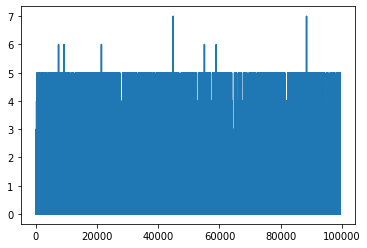

In [66]:
plt.plot(od.order_status)

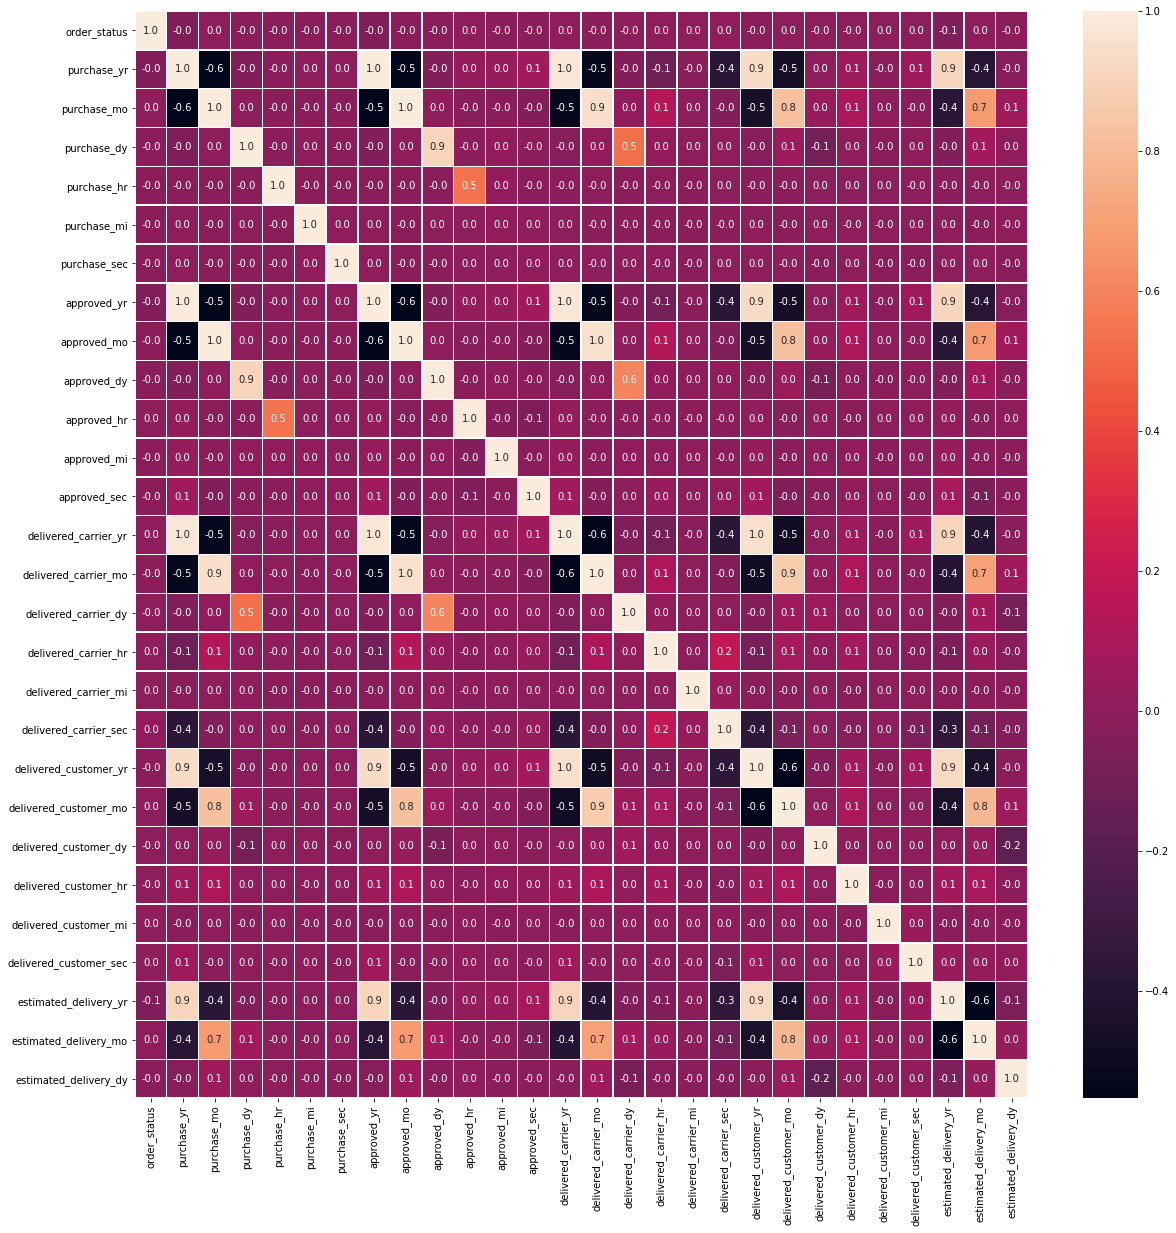

In [67]:
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(od.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [68]:
od = pd.read_csv('2new_olist_orders_dataset.csv')
od

,order_id,customer_id,order_status,purchase_yr,purchase_mo,purchase_dy,purchase_hr,purchase_mi,purchase_sec,approved_yr,...,delivered_carrier_sec,delivered_customer_yr,delivered_customer_mo,delivered_customer_dy,delivered_customer_hr,delivered_customer_mi,delivered_customer_sec,estimated_delivery_yr,estimated_delivery_mo,estimated_delivery_dy
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,0,2017,10,2,10,56,33,2017.0,...,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,0,2018,7,24,20,41,37,2018.0,...,0.0,2018.0,8.0,7.0,15.0,27.0,45.0,2018,8,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,0,2018,8,8,8,38,49,2018.0,...,0.0,2018.0,8.0,17.0,18.0,6.0,29.0,2018,9,4
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,0,2017,11,18,19,28,6,2017.0,...,59.0,2017.0,12.0,2.0,0.0,28.0,42.0,2017,12,15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,0,2018,2,13,21,18,39,2018.0,...,34.0,2018.0,2.0,16.0,18.0,17.0,2.0,2018,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,0,2017,3,9,9,54,5,2017.0,...,3.0,2017.0,3.0,17.0,15.0,8.0,1.0,2017,3,28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,0,2018,2,6,12,58,58,2018.0,...,42.0,2018.0,2.0,28.0,17.0,37.0,56.0,2018,3,2
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,0,2017,8,27,14,46,43,2017.0,...,26.0,2017.0,9.0,21.0,11.0,24.0,17.0,2017,9,27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,0,2018,1,8,21,28,27,2018.0,...,3.0,2018.0,1.0,25.0,23.0,32.0,54.0,2018,2,15
